In [1]:
!pip install -q torch torchvision

In [2]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import random
import os

from IPython.display import HTML, Image
from IPython import display

In [3]:
BASE_PATH = "./S403/hw1"
SEED = 42

os.makedirs(BASE_PATH, exist_ok=True)

# Data Exploration

In [4]:
def plot_samples(dataset, split, seed):
    np.random.seed(seed)
    print(f"MNIST Train Split Samples (seed = {seed}, {split} split)")

    plt.figure(figsize=(10, 5))

    found_samples = {i: False for i in range(10)}

    while not all(found_samples.values()):
        idx = np.random.randint(0, len(dataset))
        image , label = dataset[idx]
        if not found_samples[label]:
            # Plot the image
            plt.subplot(2, 5, label + 1)
            plt.imshow(image.squeeze(), cmap='gray')
            plt.title(f'Label: {label}')
            plt.axis('off')
            found_samples[label] = True

    # Show the plot
    plt.tight_layout()
    plt.savefig(os.path.join(BASE_PATH, "MNIST_samples_" + split + ".png"))
    plt.show()

def plot_label_distribution_histogram(dataset, split):
    labels = [label for _, label in dataset]

    counts = [labels.count(i) for i in range(10)]

    fig, ax = plt.subplots()
    ax.bar(range(10), counts)

    for i in range(10):
        ax.text(i, counts[i], f"{100*(counts[i]/sum(counts)):.1f} %", ha="center", va="bottom")

    ax.set_xlabel("Label")
    ax.set_ylabel("Count")
    ax.set_xticks(range(10))
    ax.set_xticklabels(range(10), ha="center")
    ax.set_title(f"Histogram of labels distribution for {split} split")
    plt.tight_layout()
    plt.savefig(os.path.join(BASE_PATH, "MNIST_labels_distribution_" + split + ".png"))
    plt.show()


In [5]:
scale = torchvision.transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    scale
])

train_set = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
test_set = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

print(f"Number of Train samples: {len(train_set)}")
print(f"Number of Test samples: {len(test_set)}")

100%|██████████| 9912422/9912422 [00:00<00:00, 278197028.01it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 73105427.78it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 131771423.61it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 14163961.91it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Number of Train samples: 60000
Number of Test samples: 10000


MNIST Train Split Samples (seed = 42, train_org split)


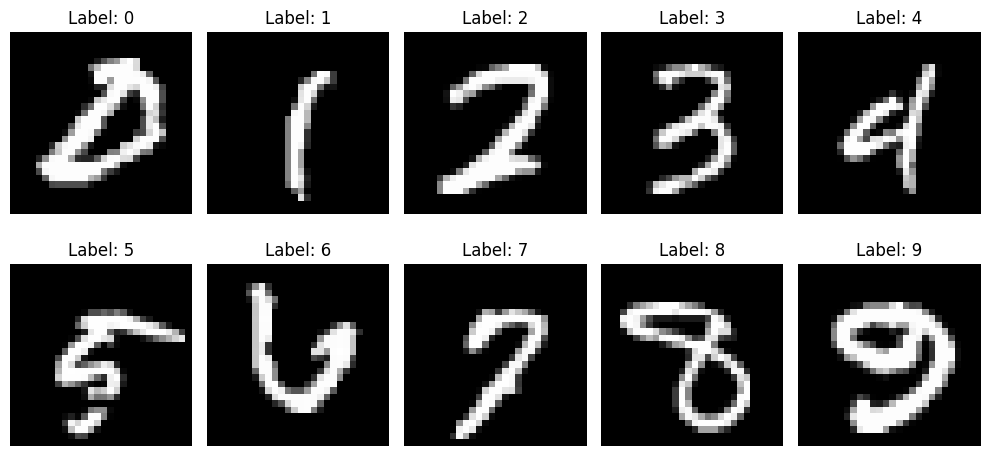

In [6]:
plot_samples(train_set, "train_org", SEED)

MNIST Train Split Samples (seed = 42, test_org split)


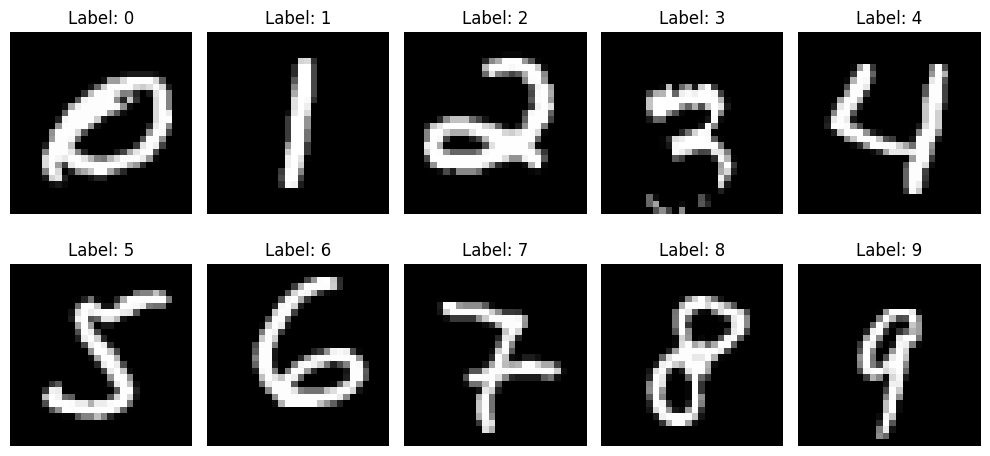

In [7]:
plot_samples(test_set, "test_org", SEED)

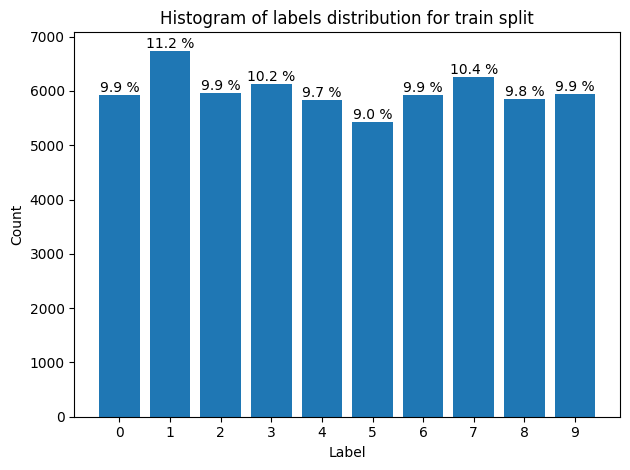

In [8]:
plot_label_distribution_histogram(train_set, "train")

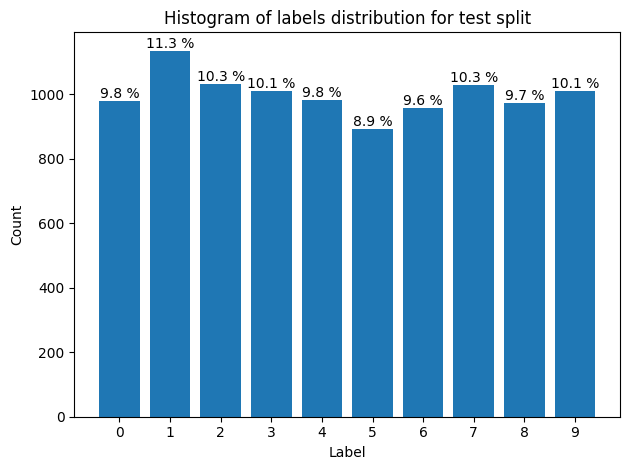

In [9]:
plot_label_distribution_histogram(test_set, "test")

# Network Structure

In [10]:
class Classifier(nn.Module):
    def __init__(
            self,
            input_size=784,
            output_size=10
    ):
        super(Classifier, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),

            nn.Linear(512, 128),
            nn.ReLU(),

            nn.Linear(128, 32),
            nn.ReLU(),

            nn.Linear(32, output_size),
        )

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        encoded = self.encoder(x)
        return encoded



# Model Training Utils

In [11]:
@torch.no_grad()
def model_eval(
        model,
        device,
        data_loader,
):
    test_loss = 0.0
    test_correct = 0
    model = model.to(device)
    loss_function = nn.CrossEntropyLoss()

    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        loss = loss_function(outputs, labels)

        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        test_correct += torch.sum(preds == labels).item()

    test_loss = test_loss / len(data_loader)
    test_acc = test_correct / len(test_set)

    return test_loss, test_acc

def train_model(
        model,
        batch_size,
        loss_function,
        optimizer_gen,
        learning_rate,
        epochs,
        train_set,
        test_set,
):
    optimizer = optimizer_gen(params=model.parameters(), lr=learning_rate)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    train_loss_list = []
    train_acc_list = []

    test_loss_list = []
    test_acc_list = []

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    model = model.to(device)

    for epoch in range(epochs):
        model.train()

        train_loss = 0.0
        train_correct = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            loss.backward()
            optimizer.step()


            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels).item()

        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / len(train_set)

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)

        model.eval()

        test_loss, test_acc = model_eval(
            model=model,
            device=device,
            data_loader=test_loader,
        )

        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)


        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {100*train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {100*test_acc:.2f}%')

    history = {
        "train loss" : train_loss_list,
        "train acc" : train_acc_list,
        "test loss" : test_loss_list,
        "test acc" : test_acc_list,
    }

    return history


In [12]:
def plot_train_history(history):
    train_loss_list = history["train loss"]
    train_acc_list = history["train acc"]
    test_loss_list = history["test loss"]
    test_acc_list = history["test acc"]

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_loss_list)+1), train_loss_list, label='Train Loss')
    plt.plot(range(1, len(test_loss_list)+1), test_loss_list, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title("Model Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_acc_list)+1), train_acc_list, label='Train Acc')
    plt.plot(range(1, len(test_acc_list)+1), test_acc_list, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title("Model Accuracy")
    plt.legend()
    plt.show()


# Train Model

## Train Config

In [13]:
T_LearningRare = 6e-5
T_BATCH_SIZE = 32
T_EPOCHS = 25

T_LOSS_F = nn.CrossEntropyLoss()
T_Optimizer_GEN = torch.optim.Adam

## Train Model

In [14]:
network = Classifier()

In [15]:
history = train_model(
    model=network,
    batch_size=T_BATCH_SIZE,
    loss_function=T_LOSS_F,
    optimizer_gen=T_Optimizer_GEN,
    learning_rate=T_LearningRare,
    epochs=T_EPOCHS,
    train_set=train_set,
    test_set=test_set,
)

Epoch 1, Train Loss: 0.7014, Train Acc: 80.91%, Test Loss: 0.3260, Test Acc: 90.84%
Epoch 2, Train Loss: 0.2862, Train Acc: 91.84%, Test Loss: 0.2425, Test Acc: 93.04%
Epoch 3, Train Loss: 0.2289, Train Acc: 93.38%, Test Loss: 0.2064, Test Acc: 94.02%
Epoch 4, Train Loss: 0.1935, Train Acc: 94.42%, Test Loss: 0.1755, Test Acc: 94.99%
Epoch 5, Train Loss: 0.1668, Train Acc: 95.17%, Test Loss: 0.1569, Test Acc: 95.35%
Epoch 6, Train Loss: 0.1455, Train Acc: 95.77%, Test Loss: 0.1475, Test Acc: 95.71%
Epoch 7, Train Loss: 0.1285, Train Acc: 96.28%, Test Loss: 0.1317, Test Acc: 96.17%
Epoch 8, Train Loss: 0.1140, Train Acc: 96.68%, Test Loss: 0.1220, Test Acc: 96.21%
Epoch 9, Train Loss: 0.1027, Train Acc: 96.98%, Test Loss: 0.1128, Test Acc: 96.56%
Epoch 10, Train Loss: 0.0930, Train Acc: 97.28%, Test Loss: 0.1057, Test Acc: 96.62%
Epoch 11, Train Loss: 0.0837, Train Acc: 97.53%, Test Loss: 0.1008, Test Acc: 96.91%
Epoch 12, Train Loss: 0.0763, Train Acc: 97.73%, Test Loss: 0.0950, Test A

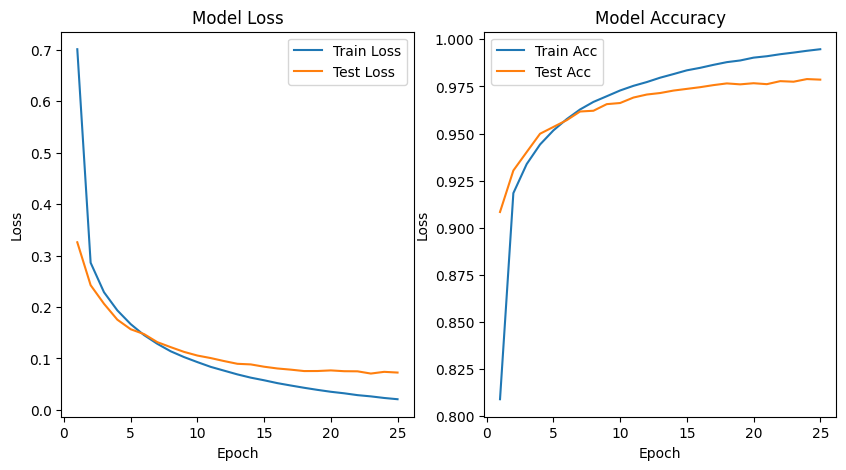

In [16]:
plot_train_history(history)

# Implement attacks

In [17]:
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
M,N = 8, 8

network = network.to(device)

for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break

In [18]:
def plot_images(X, y, yp):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

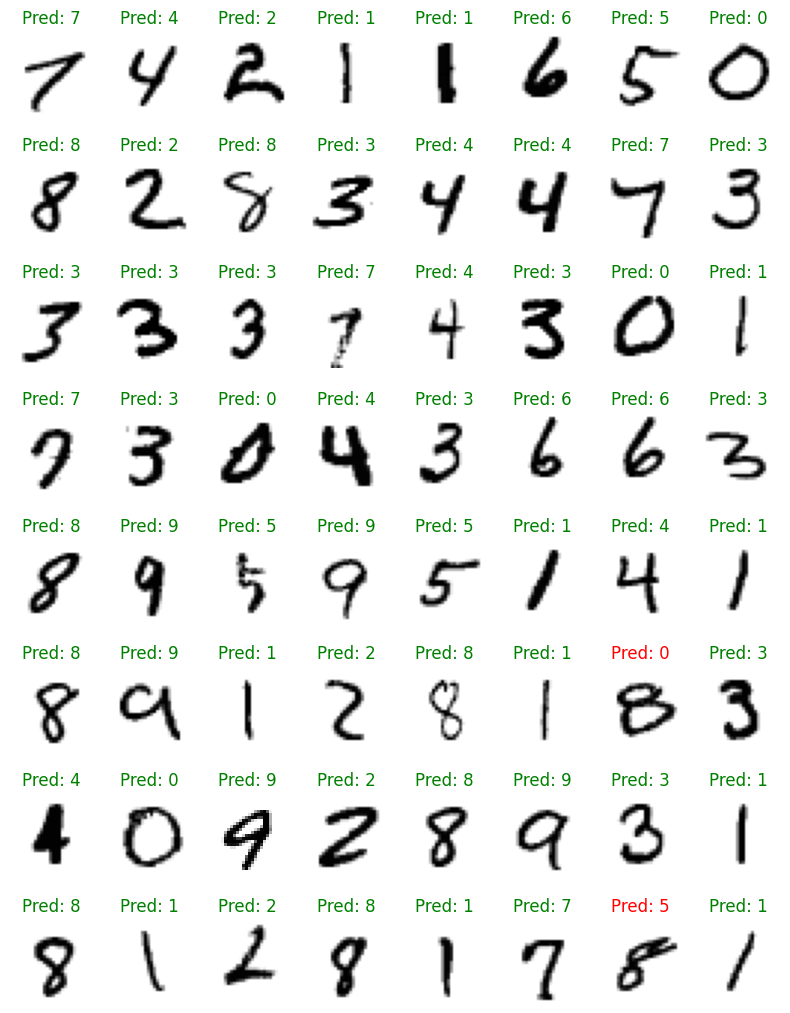

In [19]:
yp_normal = network(X)
plot_images(X, y, yp_normal)

## FGSM

In [20]:
def fgsm(model, X, y, epsilon):
    """Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

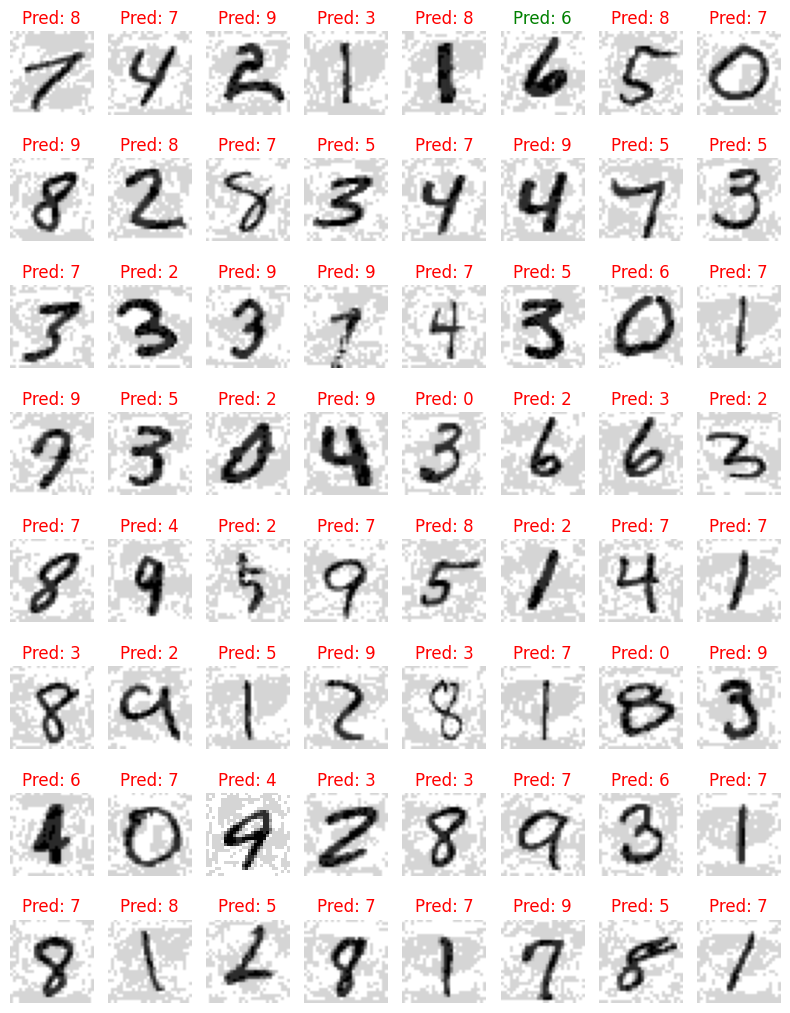

In [21]:
delta = fgsm(network, X, y, 0.1)
yp_fgsm = network(X+delta)
plot_images(X+delta, y, yp_fgsm)

## PGD

In [ ]:
def pgd(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

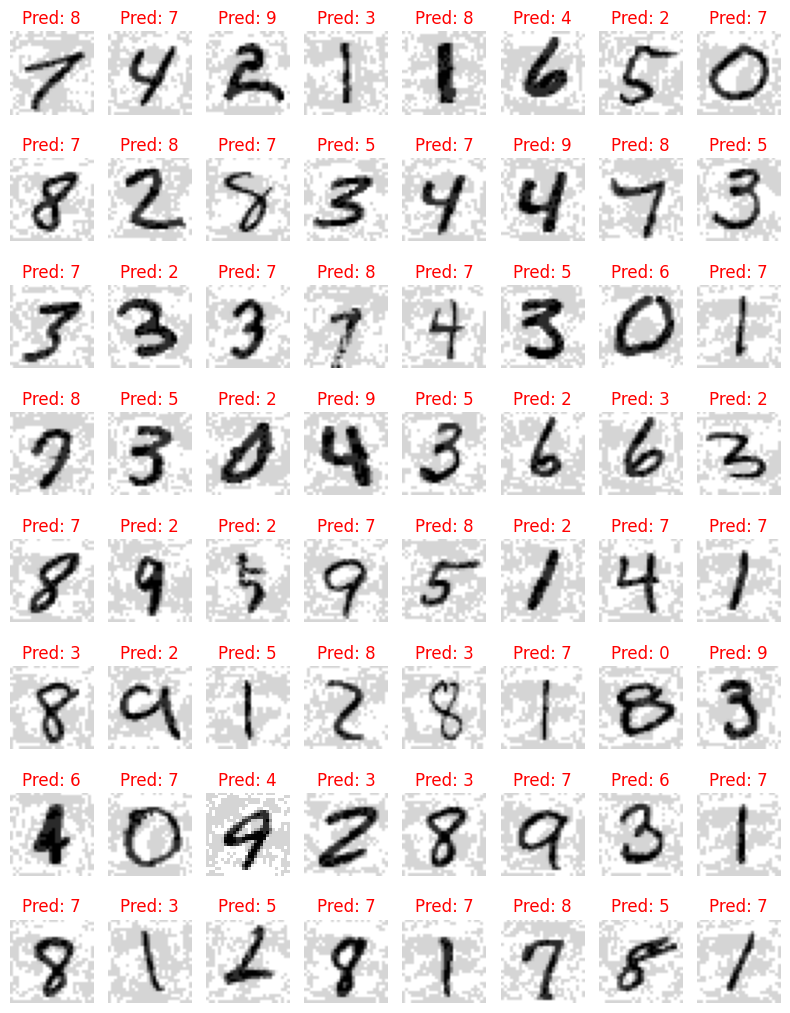

In [23]:
delta = pgd(network, X, y, 0.1, 1e4, 1000)
yp_pgd = network(X + delta)
plot_images(X+delta, y, yp_pgd)